<a href="https://colab.research.google.com/github/eursamajor/Aksara/blob/main/Rencong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### IMPORT DATA AND DATA AUGMENTATION

In [1]:
import os
import shutil
import requests
import zipfile
from io import BytesIO
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, VGG16, ResNet50, InceptionV3, DenseNet121
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
import matplotlib.pyplot as plt

In [2]:
url = 'https://github.com/eursamajor/Aksara/raw/main/Rencong.zip'

zip_path = './Rencong.zip'
extract_path = './'

response = requests.get(url)
with open(zip_path, 'wb') as f:
    f.write(response.content)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

#utk store data yang udah didownload dan extract
dataset_dir = os.path.join(extract_path, 'Rencong')

# new dir utk taroh 3 data
base_dir = './dataset_split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

for directory in [train_dir, val_dir, test_dir]:
    os.makedirs(directory, exist_ok=True)
    for class_name in os.listdir(dataset_dir):
        os.makedirs(os.path.join(directory, class_name), exist_ok=True)

# split data
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    images = os.listdir(class_path)

    train_images, temp_images = train_test_split(images, test_size=0.4, random_state=42)
    val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

    for image in train_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(train_dir, class_name, image))

    for image in val_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(val_dir, class_name, image))

    for image in test_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(test_dir, class_name, image))

#augment
img_size = (224, 224)
batch_size = 32

# train_datagen = ImageDataGenerator(rescale=1./255,
#                                    rotation_range=40,
#                                    shear_range=0.2,
#                                    zoom_range=0.2,
#                                    width_shift_range=0.2,
#                                    height_shift_range=0.2,
#                                    horizontal_flip=True,
#                                    fill_mode='nearest'
#                                    )

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
val_generator = val_datagen.flow_from_directory(val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')

Found 2991 images belonging to 20 classes.
Found 999 images belonging to 20 classes.
Found 1006 images belonging to 20 classes.


### DEFINE MODEL

In [3]:
def create_model(base_model):
    for layer in base_model.layers:
        layer.trainable = False

    x = Flatten()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

models = {
    'VGG16': VGG16(weights='imagenet', include_top=False, input_shape=(224, 224,3)),
    'ResNet50': ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    'InceptionV3': InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    'MobileNetV2': MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    'DenseNet121': DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
}

results = {}

29084464/29084464 [==============================] - 0s 0us/step


### TRAIN AND EVALUATION

In [4]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

for model_name, base_model in models.items():
    print(f"Training {model_name}...")
    model = create_model(base_model)
    history = model.fit(train_generator, validation_data=val_generator, epochs=30)

    test_loss, test_acc = model.evaluate(test_generator)
    results[model_name] = {
        'accuracy': history.history['accuracy'],
        'val_accuracy': history.history['val_accuracy'],
        'test_accuracy': test_acc
    }

Training VGG16...
Epoch 1/30
94/94 [==============================] - 31s 227ms/step - loss: 2.2438 - accuracy: 0.5276 - val_loss: 0.3776 - val_accuracy: 0.9419
Epoch 2/30
94/94 [==============================] - 17s 180ms/step - loss: 0.4012 - accuracy: 0.8887 - val_loss: 0.1342 - val_accuracy: 0.9820
Epoch 3/30
94/94 [==============================] - 16s 170ms/step - loss: 0.2054 - accuracy: 0.9452 - val_loss: 0.0594 - val_accuracy: 0.9940
Epoch 4/30
94/94 [==============================] - 16s 172ms/step - loss: 0.1213 - accuracy: 0.9719 - val_loss: 0.0306 - val_accuracy: 0.9980
Epoch 5/30
94/94 [==============================] - 16s 168ms/step - loss: 0.0857 - accuracy: 0.9813 - val_loss: 0.0216 - val_accuracy: 0.9980
Epoch 6/30
94/94 [==============================] - 16s 166ms/step - loss: 0.0651 - accuracy: 0.9856 - val_loss: 0.0172 - val_accuracy: 0.9980
Epoch 7/30
94/94 [==============================] - 16s 168ms/step - loss: 0.0583 - accuracy: 0.9863 - val_loss: 0.0109 - va

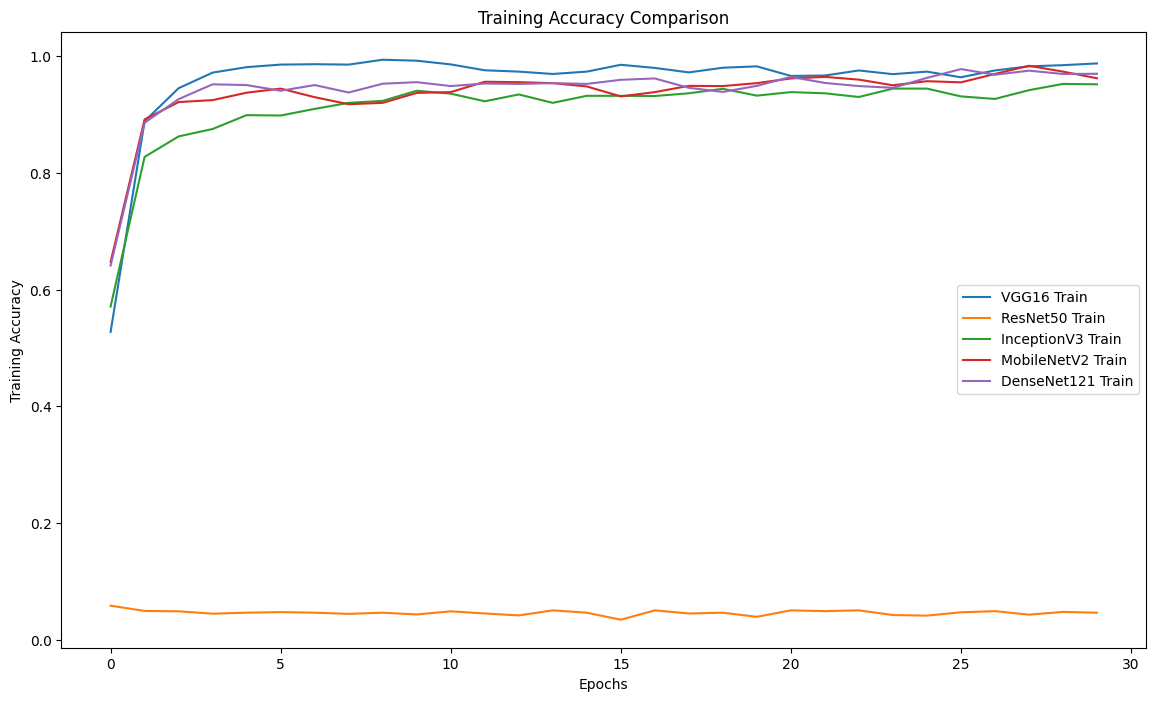

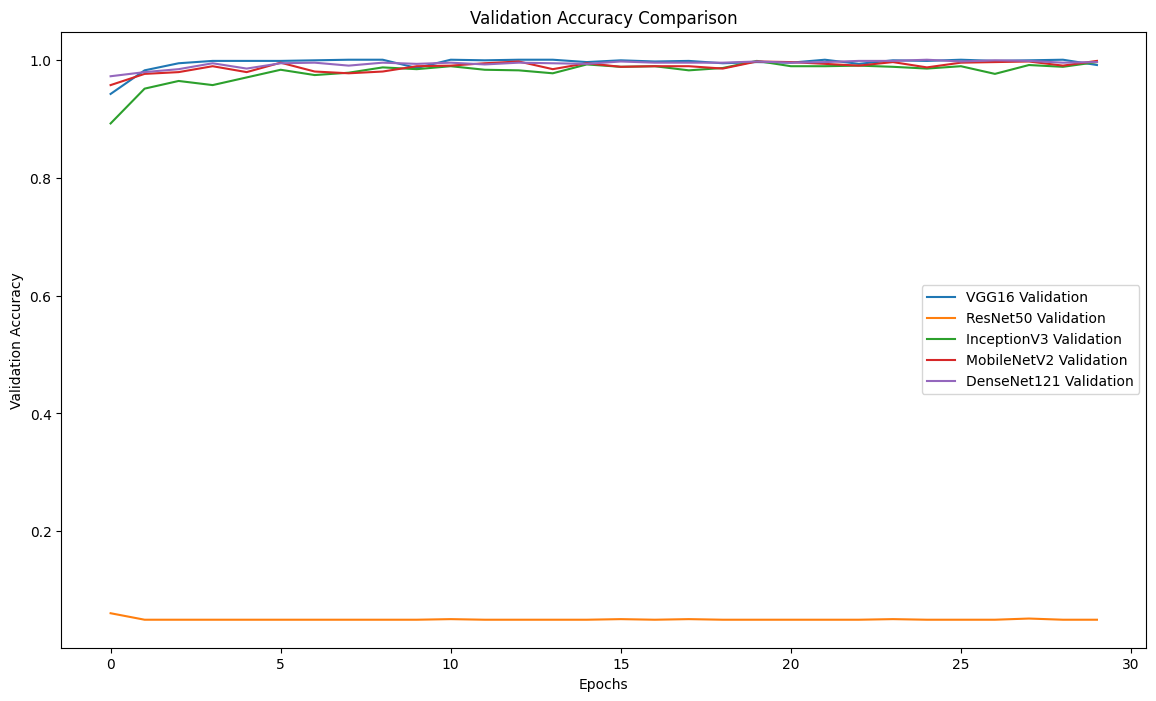

In [5]:
# Plotting Training Accuracy
plt.figure(figsize=(14, 8))
for model_name, result in results.items():
    plt.plot(result['accuracy'], label=f"{model_name} Train")
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.legend()
plt.title('Training Accuracy Comparison')
plt.grid(False)
plt.show()

# Plotting Validation Accuracy
plt.figure(figsize=(14, 8))
for model_name, result in results.items():
    plt.plot(result['val_accuracy'], label=f"{model_name} Validation")
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.title('Validation Accuracy Comparison')
plt.grid(False)
plt.show()